In [3]:
import gymnasium as gym
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
from tqdm import tqdm

#Code implementations derived from https://github.com/mimoralea/gdrl

In [4]:
class FCDAP(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim,
                 hidden_dims=(32,32), #define hidden layers as tuple where each element is an int representing # of neurons at a layer
                 activation_fc=nn.ReLU):
        super(FCDAP, self).__init__()
        self.activation_fc = activation_fc

        hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            hidden_layers.append(activation_fc())
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            activation_fc(),
            *hidden_layers,
            nn.Linear(hidden_dims[-1], output_dim)
        )

        device = "cpu"
        #if torch.cuda.is_available():
        #    device = "cuda"
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x
        
    def forward(self, state):
        x = self._format(state)
        return self.layers(x)

    #select and return action, corresponding log prob of the action, and entropy of the distribution
    def select_action(self, state):
        logits = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        return action.item(), dist.log_prob(action).unsqueeze(-1), dist.entropy().unsqueeze(-1)

![Alt text](image.png)
https://arxiv.org/pdf/1602.01783.pdf

In [64]:
import pickle
res = {}
with open('../a3c.results', 'rb') as file:
    res = pickle.load(file)

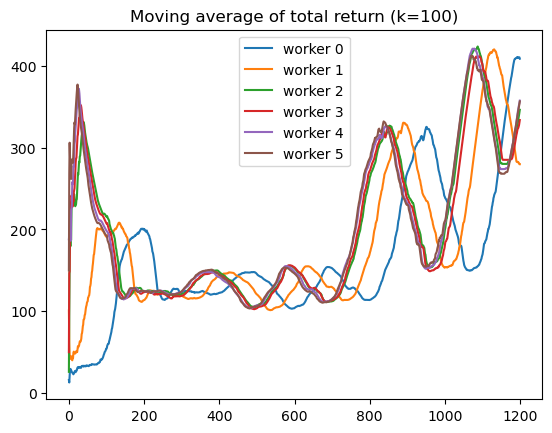

In [65]:
episode_returns = res[0]
for rank, returns_tensor in enumerate(episode_returns):
    returns = returns_tensor.numpy()
    plt.plot(range(len(returns)), [np.mean(returns[max(0,x-100):x+1]) for x in range(len(returns))], label=f'worker {rank}')
plt.title('Moving average of total return (k=100)')
plt.legend()

In [66]:
def run_discrete_policy_model(env, model, gamma=1.0, num_episodes=1, stochastic=True):
    ep_returns = []
    for _ in range(num_episodes):
        ep_return = 0
        state = env.reset()[0]
        for t in count():
            if stochastic:
                action = model.select_action(state)[0]
            else:
                action = model(state).detach().max(1).indices.view(1, 1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_return += reward * gamma**t
            state = next_state
            if terminated or truncated:
                ep_returns.append(ep_return)
                break
    return ep_returns

env = gym.make('CartPole-v1', render_mode='human')
run_discrete_policy_model(env, res[1], num_episodes=1, stochastic=True)

[152.0]

In [57]:
episode_returns.max()

tensor(500.)

In [67]:
env.close()